In [1]:
import os
import gym
import numpy as np
import torch
from tqdm import tqdm
from CustomGymEnvs import MujocoGraphWrapper, FetchReachGraphWrapper
from pathlib import Path
from Graph_SAC.sac import SAC
from utils import state_2_graphbatch, load_object
# matplotlib.use('TkAgg')
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
# env_name = 'HalfCheetah-v2'
env_name = 'Walker2d-v2'
# env_name = 'Hopper-v2'
# env_name = 'FetchReachDense-v1'

In [3]:
exp_path = os.path.join(Path(os.getcwd()), 'Data', env_name, 'graph')
obj_path = os.path.join(exp_path, 'edge_relevance.pkl')
edge_relevance = load_object(obj_path)

In [4]:
# Environment
if 'FetchReach' in env_name:
    env = FetchReachGraphWrapper(gym.make(env_name))
else:
    env = MujocoGraphWrapper(gym.make(env_name))

edge_list = env.robot_graph.edge_list
node_list = env.robot_graph.node_list

In [5]:
def process_joint_name(joint_name):
    separated = joint_name.split(':')[1].split('_') if 'robot0' in joint_name else joint_name.split('_')
    final_key = ''
    for sk in separated:
        if len(sk) == 1:
            final_key += sk + '-'
        else:
            final_key += sk + ' '
    return final_key

joint_names = []
joint_indices = []
for edge_id, joint_list in enumerate(edge_list.values()):
    if len(joint_list) > 0:
        joint_names.append(
            process_joint_name(joint_list[0].attrib['name'])
            if len(joint_list) == 1
            else '\n'.join([process_joint_name(j.attrib['name']) for j in joint_list])
        )
        joint_indices.append(edge_id)

action_indices = [a for a in range(env.action_space.shape[0])]

In [6]:
def plot_joint_action_heatmap(data, importance, width, height, title):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(width, height), gridspec_kw={'width_ratios': (30, 1)})
    sns.heatmap(data, ax=ax1, cbar=False, cmap="YlGn", linewidth=1, vmin=np.min(data), vmax=np.max(data))
    ax1.set_xticks(np.arange(len(joint_names)) + 0.5, labels=[j for j in joint_names], rotation=45)
    ax1.set_title(title, fontsize=20, pad=40)
    ax1.set_ylabel("Action index")
    ax1.set_xlabel(f"Joints' names")

    ax3 = ax1.twiny()
    ax3.set_xlim([0, ax1.get_xlim()[1]])
    ax3.set_xticks(ax1.get_xticks())
    ax3.set_xticklabels(np.round(importance, 2))

    plt.colorbar(plt.cm.ScalarMappable(cmap="YlGn", norm=plt.Normalize(vmin=np.min(data), vmax=np.max(data))), cax=ax2)
    ax2.yaxis.set_ticks_position('left')
    ax2.set_ylabel('Avg relevance score across seeds')

    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            ax1.text(j + 0.5, i + 0.5, round(data[i, j], 3), color="black")

    plt.show()
    fig.savefig(os.path.join(exp_path, 'LRP_result.jpg'), dpi=300)

In [7]:
# avg_edge_rel = np.abs(edge_relevance).mean(axis=4).mean(axis=3).mean(axis=2)
# avg_edge_rel = np.abs(edge_relevance).sum(axis=4).sum(axis=3).sum(axis=2)
avg_edge_rel = edge_relevance.mean(axis=4).mean(axis=3).mean(axis=2)

avg_edge_rel /= np.max(np.abs(avg_edge_rel), axis=0)

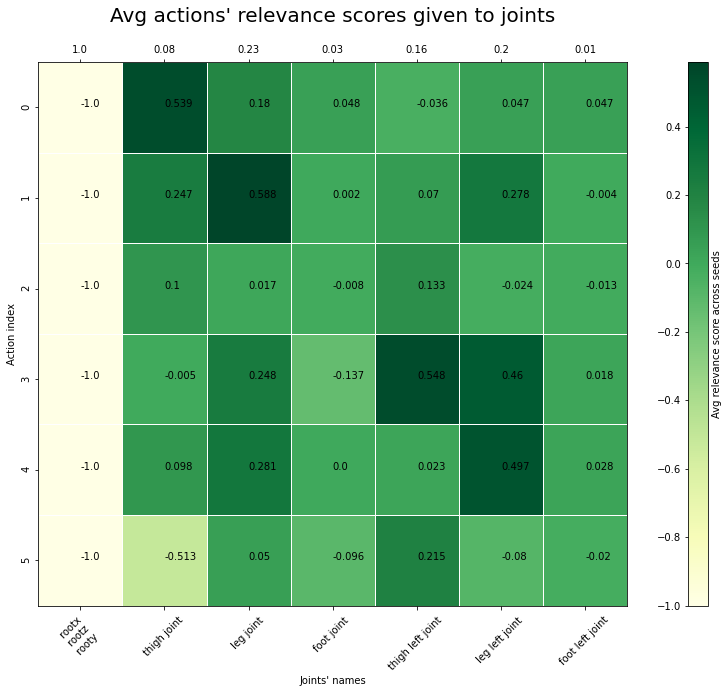

In [8]:
figure_width = 12
figure_height = 10

# data = np.abs(avg_edge_rel.T)
importance = np.abs(avg_edge_rel.T.mean(axis=0))
data = avg_edge_rel.T

plot_joint_action_heatmap(data, importance,
                          figure_width,
                          figure_height,
                          "Avg actions' relevance scores given to joints")